In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch

import torch.nn as nn

# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to get the digit dataset
import torchvision.datasets as dsets


import matplotlib.pyplot as plt
import numpy as np

<br>

In [3]:
# The function to plot parameters

def PlotParameters(model): 
    W = model.state_dict()['linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            
            # Set the label for the sub-plot.
            ax.set_xlabel("class: {0}".format(i))

            # Plot the image.
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')

            ax.set_xticks([])
            ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [4]:
# Plot the image data as image

def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    # plt.title('y = ' + str(data_sample[1].item()))       # 陈锐平注销
    plt.title('y = ' + str(data_sample[1]))

<br>
<br>

## Download Dataset

In [5]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, 
                            transform=transforms.ToTensor())

validation_dataset = dsets.MNIST(root='./data', download=True, 
                                 transform=transforms.ToTensor())

In [6]:
len(train_dataset)          # 60000

# type(train_dataset[0])          # tuple。具体为：(图像的 tensor, 数字标签)
# train_dataset[0]
train_dataset[0][0].shape  # torch.Size([1, 28, 28])

torch.Size([1, 28, 28])

The label:  1


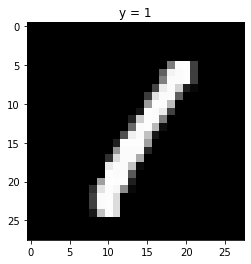

In [7]:
print("The label: ", train_dataset[3][1])   # Print out the label of the fourth element
show_data(train_dataset[3])

<br>
<br>

## Create Softmax Classifer

In [8]:
# Define softmax classifier class
# Inherits nn.Module which is the base class for all neural networks
class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        # Creates a layer of given input size and output size
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        # Runs the x value through the single layers defined above
        z = self.linear(x)
        return z

In [9]:
# Set input size and output size
input_dim = 28 * 28
output_dim = 10

# Create the model
# Input dim is 28*28 which is the image converted to a tensor
# Output dim is 10 because there are 10 possible digits the image can be
model = SoftMax(input_dim, output_dim)

In [10]:
# Print the parameters
print('W: ',list(model.parameters())[0].size())   # W: torch.Size([10, 784])
print('b: ',list(model.parameters())[1].size())   # b: torch.Size([10])

W:  torch.Size([10, 784])
b:  torch.Size([10])


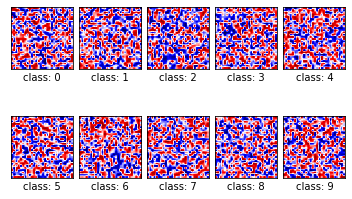

In [11]:
# Plot the model parameters for each class
# Since the model has not been trained yet the parameters look random
PlotParameters(model)

<br>
<br>

## Create Loss Function

### Cross Entropy Loss

In [12]:
# The criterion will measure the loss between the prediction and actual label values
# This is where the SoftMax occurs, it is built into the Criterion Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# The criterion will take these values and return a loss
#criterion(model_output, actual)

In [13]:
X = train_dataset[0][0]    # Get the X value of the first image.
X.shape                    # torch.Size([1, 28, 28]). We need it to be flattened to 1 by 28 * 28 (784).
X = X.view(-1, 28*28)
X.shape                    # torch.Size([1, 784])

# Now we can make a prediction, each class has a value, 
# and the higher it is the more confident the model is that it is that digit
model(X)

tensor([[-0.0565, -0.2266, -0.7444,  0.1747,  0.1896,  0.1744, -0.1666,  0.0950,
         -0.1182,  0.5686]], grad_fn=<AddmmBackward0>)

Output:  tensor([[-0.0565, -0.2266, -0.7444,  0.1747,  0.1896,  0.1744, -0.1666,  0.0950,
         -0.1182,  0.5686]], grad_fn=<AddmmBackward0>)
Actual: tensor([5])


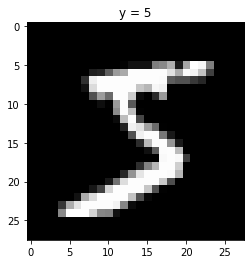

In [14]:
model_output = model(X)
actual = torch.tensor([train_dataset[0][1]])

show_data(train_dataset[0])
print("Output: ", model_output)
print("Actual:", actual)

In [15]:
# The criterion will take these values and return a loss
criterion(model_output, actual)

tensor(2.1682, grad_fn=<NllLossBackward0>)

Cross Entropy Loss takes probabilities and we can see that `model_output` are not probabilities, this is where softmax comes in

In [16]:
softmax = nn.Softmax(dim=1)
probability = softmax(model_output)
probability

tensor([[0.0908, 0.0766, 0.0456, 0.1144, 0.1161, 0.1144, 0.0813, 0.1057, 0.0854,
         0.1697]], grad_fn=<SoftmaxBackward0>)

Now that we have probabilities, we can just calculate the negative log of the probability of the class that this image belongs to. The image belongs to the target class so we calculate the negative log of the probability at the target index.

In [17]:
-1*torch.log(probability[0][actual])

# We can see the result above matches the result of the criterion, 
# this is how Cross Entropy Loss uses Softmax.

tensor([2.1682], grad_fn=<MulBackward0>)

<br>
<br>

## Setting the Batch Size using a DataLoader

In [18]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

<br>
<br>

## Create Optimizer and Setting Learning rate

In [19]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

<br>
<br>

## Train Model

In [20]:
n_epochs = 10         # Number of times we train our model useing the training data
loss_list = []        # Lists to keep track of loss
accuracy_list = []    # Keeps track of the accuracy

N_test = len(validation_dataset)    # Size of the validation data

# Function to train the model based on number of epochs
def train_model(n_epochs):
    
    for epoch in range(n_epochs):
        # For each batch in the train loader
        for x, y in train_loader:
            # Resets the calculated gradient value, 
            # this must be done each time as it accumulates if we do not reset
            optimizer.zero_grad()
            # Makes a prediction based on the image tensor
            z = model(x.view(-1, 28 * 28))
            # Calculates loss between the model output and actual class
            loss = criterion(z, y)
            # Calculates the gradient value with respect to each weight and bias
            loss.backward()
            # Updates the weight and bias according to calculated gradient value
            optimizer.step()
        
        # Each epoch we check how the model performs with data it has not seen 
        # which is the validation data, we are not training here
        correct = 0
        # For each batch in the validation loader
        for x_test, y_test in validation_loader:
            # Makes prediction based on image tensor
            z = model(x_test.view(-1, 28 * 28))
            # Finds the class with the higest output
            _, yhat = torch.max(z.data, 1)
            # Checks if the prediction matches the actual class and increments correct if it does
            correct += (yhat == y_test).sum().item()
        
        accuracy = correct / N_test
        
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

# Function call
train_model(n_epochs)

<br>
<br>

## Analyze Results

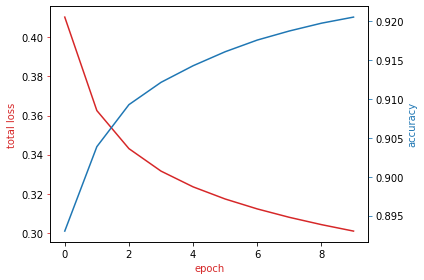

In [21]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

### Plot the parameters
View the results of the parameters for each class after the training. You can see that they look like the corresponding numbers.

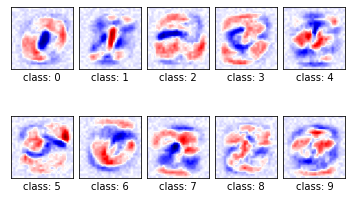

In [22]:
PlotParameters(model)

### Plot the first five misclassified samples and the probability of that class.

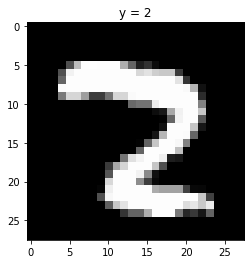

yhat: tensor([7])
probability of class  0.6892229914665222


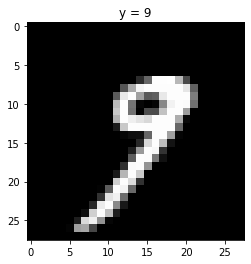

yhat: tensor([7])
probability of class  0.7201607823371887


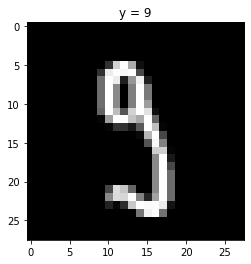

yhat: tensor([5])
probability of class  0.7257161736488342


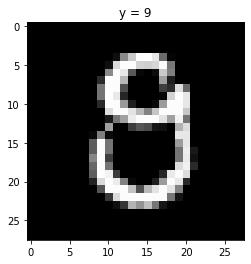

yhat: tensor([8])
probability of class  0.37328699231147766


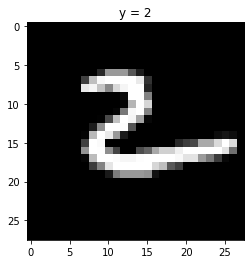

yhat: tensor([6])
probability of class  0.5239031314849854


In [23]:
Softmax_fn = nn.Softmax(dim=-1)
count = 0

for x, y in validation_dataset:
    z = model(x.reshape(-1, 28 * 28))
    _, yhat = torch.max(z, 1)           # Returns a namedtuple (values, indices)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat:", yhat)
        print("probability of class ", torch.max(Softmax_fn(z)).item() )
        count += 1
    if count >= 5:
        break       